# Data Preparation

## Setup

In [ ]:
import sys
!{sys.executable} -m pip install -r requirements.txt

In [1]:
from neo4j import GraphDatabase

uri = "neo4j://localhost:7687"
driver = GraphDatabase.driver(uri)

## Project Graph

In [2]:
with driver.session() as session:
    result = session.run('''
        CALL gds.graph.project(
            'userInteractionGraph',
            ['User'],
            [
                {INTERACTION: {orientation: 'UNDIRECTED',aggregation: 'SINGLE'} }
            ]
        )
        YIELD graphName AS graph, nodeProjection, nodeCount AS nodes, relationshipProjection, relationshipCount AS rels
''')

In [ ]:
with driver.session() as session:
    session.run('''
    CALL gds.graph.drop('userInteractionGraph', false) YIELD graphName;
''')

## Ground Truth Generation

Calculate Neighborhood Overlap:

In [16]:
with driver.session() as session:
    result = session.run('''
        CALL gds.nodeSimilarity.stream('userInteractionGraph', { topK: 7000 })
        YIELD node1, node2, similarity
        WITH gds.util.asNode(node1) AS u1, gds.util.asNode(node2) AS u2, similarity
        MATCH (u1)-[i:INTERACTION]-(u2)
        WITH u1, u2, i, similarity
        CALL{
            WITH u1, u2, i, similarity
            SET i.neighbourhoodOverlap = similarity          
        } IN TRANSACTIONS OF 1000 ROWS
''')

ClientError: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.nodeSimilarity.stream`: Caused by: java.lang.IllegalStateException: Procedure was blocked since minimum estimated memory (5203 MiB) exceeds current free memory (5120 MiB). Note: there are 1 graphs currently loaded into memory. (Transactions committed: 0)}

Local Clustering Coefficient:

In [ ]:
with driver.session() as session:
    result = session.run('''
    CALL gds.localClusteringCoefficient.write('userInteractionGraph', {
    writeProperty: 'localClusteringCoefficient'
    })
    YIELD averageClusteringCoefficient, nodeCount
''')

Min Local Clustering Coefficient:

In [ ]:
with driver.session() as session:
    result = session.run('''
    CALL {
        MATCH p=(u1:User)-[i:INTERACTION]-(u2:User) 
        RETURN u1, u2, i
    }
    WITH u1, u2, i,
        CASE WHEN u1.localClusteringCoefficient < u2.localClusteringCoefficient
            THEN u1.localClusteringCoefficient
            ELSE u2.localClusteringCoefficient
        END AS minLocalClusterinCoefficient       
    CALL {
        WITH u1, u2, i, minLocalClusterinCoefficient
        SET i.minLocalClusterinCoefficient = minLocalClusterinCoefficient
    } IN TRANSACTIONS OF 1000 ROWS
''')

Tie Strength:

In [19]:
with driver.session() as session:
    result = session.run('''
    CALL {
        MATCH p=(u1:User)-[i:INTERACTION]-(u2:User) 
        RETURN u1, u2, p, i
    }
    WITH u1, u2, i,
        CASE WHEN i.minLocalClusterinCoefficient IS NULL OR i.neighbourhoodOverlap IS NULL
            THEN NULL
            ELSE (i.minLocalClusterinCoefficient * 0.5) + (i.neighbourhoodOverlap * 0.5) 
        END AS tieStrength
    CALL {
        WITH u1, u2, i, tieStrength
        SET i.tieStrength = tieStrength
    } IN TRANSACTIONS OF 1000 ROWS
''')

## Feature Genration

Interaction Frequency:

In [ ]:
with driver.session() as session:
    result = session.run('''
    CALL {
        MATCH p=(u1:User)-[i:INTERACTION]-(u2:User) 
        RETURN u1, u2, p, i
    }
    WITH u1, u2, i,
        CASE WHEN i.upvotes IS NULL
            THEN 0.0
            ELSE i.upvotes
        END AS upvotes,
        CASE WHEN i.downvotes IS NULL
            THEN 0.0
            ELSE i.downvotes
        END AS downvotes,
        CASE WHEN i.postings IS NULL
            THEN 0.0
            ELSE i.postings
        END AS postings
    CALL {
        WITH u1, u2, i, upvotes, downvotes, postings
        SET i.interactionFrequency = upvotes + downvotes + postings
    } IN TRANSACTIONS OF 1000 ROWS
''')

Sentiment:

In [23]:
with driver.session() as session:
    result = session.run('''
    CALL {
        MATCH p=(u1:User)-[i:INTERACTION]-(u2:User) 
        RETURN u1, u2, p, i
    }
    WITH u1, u2, i,
        CASE WHEN i.upvotes IS NULL
            THEN 0.0
            ELSE toFloat(i.upvotes)
        END AS upvotes,
        CASE WHEN i.downvotes IS NULL
            THEN 0.0
            ELSE toFloat(i.downvotes)
        END AS downvotes,
        CASE WHEN i.follows IS NULL
            THEN 0.0
            ELSE toFloat(i.follows)
        END AS follows,
        CASE WHEN i.ignores IS NULL
            THEN 0.0
            ELSE toFloat(i.ignores)
        END AS ignores        
    WITH u1, u2, i, 
        CASE WHEN upvotes + downvotes = 0.0
            THEN 0.0
            ELSE (((upvotes / (upvotes + downvotes)) - (downvotes / (upvotes + downvotes))) * (0.5))
        END AS voting_sentiment,
        CASE WHEN follows + ignores = 0.0
            THEN 0.0
            ELSE (((follows / (follows + ignores)) - (ignores / (follows + ignores))) * (0.5))
        END AS following_sentiment
    CALL {
        WITH u1, u2, i, voting_sentiment, following_sentiment
        SET i.sentiment = voting_sentiment + following_sentiment
    } IN TRANSACTIONS OF 1000 ROWS
''')

Closeness:

In [3]:
with driver.session() as session:
    result = session.run('''
    CALL {
        MATCH p=(u1:User)-[i:INTERACTION]-(u2:User) 
        RETURN u1, u2, p, i
    }
    WITH u1, u2, i
    CALL {
        WITH u1, u2, i
        MATCH pn=(u1)-[i1:INTERACTION]-(un:User)-[i2:INTERACTION]-(u2)
        WHERE i1.follows = 2 AND i2.follows = 2
        RETURN COUNT(DISTINCT un) as common_friends
    }
    WITH u1, u2, i, common_friends
    CALL {
        WITH u1, u2, i, common_friends
        SET i.closeness = common_friends
    } IN TRANSACTIONS OF 1000 ROWS
''')

Reciprocity

In [ ]:
with driver.session() as session:
    result = session.run('''
    CALL {
        MATCH p=(u1:User)-[i:INTERACTION]-(u2:User) 
        RETURN u1, u2, p, i
    }
    WITH u1, u2, i,
        CASE WHEN i.follows IS NULL
            THEN 0
            ELSE i.follows
        END AS follows
    WITH u1, u2, i,
        CASE WHEN follows = 2
            THEN 1
            ELSE 0
        END AS reciprocity
    CALL {
        WITH u1, u2, i, reciprocity
        SET i.reciprocity = reciprocity
    } IN TRANSACTIONS OF 1000 ROWS
''')

Multiplexity

In [ ]:
with driver.session() as session:
    result = session.run('''
    CALL {
        MATCH p=(u1:User)-[i:INTERACTION]-(u2:User) 
        RETURN u1, u2, p, i
    }
    WITH u1, u2, i,
        CASE WHEN i.channels IS NULL
            THEN 0
            ELSE i.channels
        END AS channels          
    CALL {
        WITH u1, u2, i, channels
        SET i.multiplexity = channels
    } IN TRANSACTIONS OF 1000 ROWS
''')

## Interaction Export

In [24]:
with driver.session() as session:
    result = session.run('''
    WITH "MATCH (u1:User) -[i:INTERACTION]- (u2:User)
        WHERE u1.id < u2.id
        RETURN 'u' + u1.id AS `:START_ID`, 'u' + u2.id AS `:END_ID`, i.postings AS `postings:long`, i.channels AS `channels:long`, i.upvotes AS `upvotes:long`, i.downvotes AS `downvotes:long`, i.follows AS `follows:long`, i.ignores AS `ignores:long`, i.neighbourhoodOverlap AS `neighbourhoodOverlap:float`, i.minLocalClusterinCoefficient AS `minLocalClusterinCoefficient:float`, i.tieStrength AS `tieStrength:float`, i.reciprocity AS `reciprocity:float`, i.multiplexity AS `multiplexity:long`, i.closeness AS `closeness:long`, i.sentiment AS `sentiment:float`, i.interactionFrequency AS `interactionFrequency:float`
        ORDER BY u1.id, u2.id" AS query
    CALL apoc.export.csv.query(query, "interaction-final.csv", {quotes: "ifNeeded"})
    YIELD file, source, format, nodes, relationships, properties, time, rows, batchSize, batches, done, data
    RETURN file, source, format, nodes, relationships, properties, time, rows, batchSize, batches, done, data
''')

In [25]:
!docker cp tie-strength-prediction-neo4j-1:/var/lib/neo4j/import/interaction-final.csv graph/

Preparing to copy...Copying from container - 0B5.47MB20.4MB36.4MB

52.6MB68.1MB83.6MB99.5MB116MB134MB151MB168MB186MB202MB220MB237MB254MB271MB288MBSuccessfully copied 296MB to /home/christopher/projects/tu-vienna/tie-strength-prediction/graph/


Sample Connected Nodes:

## Split Generation

In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

Read the data from the csv file

In [55]:
df = pd.read_csv('graph/interaction-final.csv', sep=',', header=0)

display(df)

,:START_ID,:END_ID,postings:long,channels:long,upvotes:long,downvotes:long,follows:long,ignores:long,neighbourhoodOverlap:float,minLocalClusterinCoefficient:float,tieStrength:float,reciprocity:float,multiplexity:long,closeness:long,sentiment:float,interactionFrequency:float
0,u4,u6602,NaN,1.0,NaN,1.0,NaN,NaN,0.000644,0.138182,0.069413,0.0,1,0,-0.5,1.0
1,u4,u502011,NaN,1.0,1.0,NaN,NaN,NaN,0.003497,0.153103,0.078300,0.0,1,0,0.5,1.0
2,u4,u536995,NaN,1.0,1.0,NaN,NaN,NaN,NaN,0.167602,NaN,0.0,1,0,0.5,1.0
3,u4,u577993,NaN,1.0,1.0,NaN,NaN,NaN,0.000848,0.108038,0.054443,0.0,1,0,0.5,1.0
4,u4,u600252,NaN,NaN,NaN,NaN,1.0,NaN,0.001405,0.105190,0.053297,0.0,0,0,0.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092794,u694297,u694302,NaN,1.0,NaN,1.0,NaN,NaN,0.022472,0.259384,0.140928,0.0,1,0,-0.5,1.0
3092795,u694312,u694329,NaN,1.0,1.0,NaN,NaN,NaN,0.034043,0.170842,0.102442,0.0,1,0,0.5,1.0
3092796,u694312,u694333,NaN,1.0,1.0,NaN,NaN,NaN,0.020942,0.170842,0.095892,0.0,1,0,0.5,1.0
3092797,u694313,u694408,NaN,1.0,1.0,NaN,NaN,NaN,NaN,0.000000,NaN,0.0,1,0,0.5,1.0


Remove interactions without tie strength

In [56]:
df = df[df['tieStrength:float'].notna()]

display(df)

,:START_ID,:END_ID,postings:long,channels:long,upvotes:long,downvotes:long,follows:long,ignores:long,neighbourhoodOverlap:float,minLocalClusterinCoefficient:float,tieStrength:float,reciprocity:float,multiplexity:long,closeness:long,sentiment:float,interactionFrequency:float
0,u4,u6602,NaN,1.0,NaN,1.0,NaN,NaN,0.000644,0.138182,0.069413,0.0,1,0,-0.5,1.0
1,u4,u502011,NaN,1.0,1.0,NaN,NaN,NaN,0.003497,0.153103,0.078300,0.0,1,0,0.5,1.0
3,u4,u577993,NaN,1.0,1.0,NaN,NaN,NaN,0.000848,0.108038,0.054443,0.0,1,0,0.5,1.0
4,u4,u600252,NaN,NaN,NaN,NaN,1.0,NaN,0.001405,0.105190,0.053297,0.0,0,0,0.5,0.0
5,u4,u679697,NaN,1.0,1.0,NaN,NaN,NaN,0.002339,0.164165,0.083252,0.0,1,0,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092793,u694269,u694365,1.0,2.0,3.0,NaN,2.0,NaN,0.380952,0.385965,0.383459,1.0,2,0,1.0,4.0
3092794,u694297,u694302,NaN,1.0,NaN,1.0,NaN,NaN,0.022472,0.259384,0.140928,0.0,1,0,-0.5,1.0
3092795,u694312,u694329,NaN,1.0,1.0,NaN,NaN,NaN,0.034043,0.170842,0.102442,0.0,1,0,0.5,1.0
3092796,u694312,u694333,NaN,1.0,1.0,NaN,NaN,NaN,0.020942,0.170842,0.095892,0.0,1,0,0.5,1.0


Remove unused columns

In [57]:
df = df.drop([':START_ID', ':END_ID', ], axis=1)

display(df)

,postings:long,channels:long,upvotes:long,downvotes:long,follows:long,ignores:long,neighbourhoodOverlap:float,minLocalClusterinCoefficient:float,tieStrength:float,reciprocity:float,multiplexity:long,closeness:long,sentiment:float,interactionFrequency:float
0,NaN,1.0,NaN,1.0,NaN,NaN,0.000644,0.138182,0.069413,0.0,1,0,-0.5,1.0
1,NaN,1.0,1.0,NaN,NaN,NaN,0.003497,0.153103,0.078300,0.0,1,0,0.5,1.0
3,NaN,1.0,1.0,NaN,NaN,NaN,0.000848,0.108038,0.054443,0.0,1,0,0.5,1.0
4,NaN,NaN,NaN,NaN,1.0,NaN,0.001405,0.105190,0.053297,0.0,0,0,0.5,0.0
5,NaN,1.0,1.0,NaN,NaN,NaN,0.002339,0.164165,0.083252,0.0,1,0,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092793,1.0,2.0,3.0,NaN,2.0,NaN,0.380952,0.385965,0.383459,1.0,2,0,1.0,4.0
3092794,NaN,1.0,NaN,1.0,NaN,NaN,0.022472,0.259384,0.140928,0.0,1,0,-0.5,1.0
3092795,NaN,1.0,1.0,NaN,NaN,NaN,0.034043,0.170842,0.102442,0.0,1,0,0.5,1.0
3092796,NaN,1.0,1.0,NaN,NaN,NaN,0.020942,0.170842,0.095892,0.0,1,0,0.5,1.0


In [58]:
df = df.rename({'postings:long': 'postings', 'channels:long': 'channels', 'upvotes:long': 'upvotes', 'downvotes:long': 'downvotes', 'follows:long': 'follows', 'ignores:long': 'ignores', 'neighbourhoodOverlap:float': 'neighbourhoodOverlap', 'minLocalClusterinCoefficient:float': 'minLocalClusterinCoefficient', 'tieStrength:float': 'tieStrength', 'reciprocity:float': 'reciprocity', 'multiplexity:long': 'multiplexity', 'closeness:long': 'closeness', 'sentiment:float': 'sentiment', 'interactionFrequency:float': 'interactionFrequency'}, axis=1)
df

,postings,channels,upvotes,downvotes,follows,ignores,neighbourhoodOverlap,minLocalClusterinCoefficient,tieStrength,reciprocity,multiplexity,closeness,sentiment,interactionFrequency
0,NaN,1.0,NaN,1.0,NaN,NaN,0.000644,0.138182,0.069413,0.0,1,0,-0.5,1.0
1,NaN,1.0,1.0,NaN,NaN,NaN,0.003497,0.153103,0.078300,0.0,1,0,0.5,1.0
3,NaN,1.0,1.0,NaN,NaN,NaN,0.000848,0.108038,0.054443,0.0,1,0,0.5,1.0
4,NaN,NaN,NaN,NaN,1.0,NaN,0.001405,0.105190,0.053297,0.0,0,0,0.5,0.0
5,NaN,1.0,1.0,NaN,NaN,NaN,0.002339,0.164165,0.083252,0.0,1,0,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092793,1.0,2.0,3.0,NaN,2.0,NaN,0.380952,0.385965,0.383459,1.0,2,0,1.0,4.0
3092794,NaN,1.0,NaN,1.0,NaN,NaN,0.022472,0.259384,0.140928,0.0,1,0,-0.5,1.0
3092795,NaN,1.0,1.0,NaN,NaN,NaN,0.034043,0.170842,0.102442,0.0,1,0,0.5,1.0
3092796,NaN,1.0,1.0,NaN,NaN,NaN,0.020942,0.170842,0.095892,0.0,1,0,0.5,1.0


In [59]:
df = df.fillna(0)
df

,postings,channels,upvotes,downvotes,follows,ignores,neighbourhoodOverlap,minLocalClusterinCoefficient,tieStrength,reciprocity,multiplexity,closeness,sentiment,interactionFrequency
0,0.0,1.0,0.0,1.0,0.0,0.0,0.000644,0.138182,0.069413,0.0,1,0,-0.5,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.003497,0.153103,0.078300,0.0,1,0,0.5,1.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.000848,0.108038,0.054443,0.0,1,0,0.5,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.001405,0.105190,0.053297,0.0,0,0,0.5,0.0
5,0.0,1.0,1.0,0.0,0.0,0.0,0.002339,0.164165,0.083252,0.0,1,0,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092793,1.0,2.0,3.0,0.0,2.0,0.0,0.380952,0.385965,0.383459,1.0,2,0,1.0,4.0
3092794,0.0,1.0,0.0,1.0,0.0,0.0,0.022472,0.259384,0.140928,0.0,1,0,-0.5,1.0
3092795,0.0,1.0,1.0,0.0,0.0,0.0,0.034043,0.170842,0.102442,0.0,1,0,0.5,1.0
3092796,0.0,1.0,1.0,0.0,0.0,0.0,0.020942,0.170842,0.095892,0.0,1,0,0.5,1.0


In [60]:
normalized_df=(df-df.min())/(df.max()-df.min())
normalized_df

,postings,channels,upvotes,downvotes,follows,ignores,neighbourhoodOverlap,minLocalClusterinCoefficient,tieStrength,reciprocity,multiplexity,closeness,sentiment,interactionFrequency
0,0.000000,0.052632,0.000000,0.004329,0.0,0.0,0.000710,0.126990,0.078947,0.0,0.052632,0.0,0.25,0.001613
1,0.000000,0.052632,0.001996,0.000000,0.0,0.0,0.004915,0.142104,0.090150,0.0,0.052632,0.0,0.75,0.001613
3,0.000000,0.052632,0.001996,0.000000,0.0,0.0,0.001011,0.096454,0.060074,0.0,0.052632,0.0,0.75,0.001613
4,0.000000,0.000000,0.000000,0.000000,0.5,0.0,0.001832,0.093569,0.058630,0.0,0.000000,0.0,0.75,0.000000
5,0.000000,0.052632,0.001996,0.000000,0.0,0.0,0.003209,0.153310,0.096394,0.0,0.052632,0.0,0.75,0.001613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092793,0.002976,0.105263,0.005988,0.000000,1.0,0.0,0.561299,0.377990,0.474865,1.0,0.105263,0.0,1.00,0.006452
3092794,0.000000,0.052632,0.000000,0.004329,0.0,0.0,0.032885,0.249765,0.169106,0.0,0.052632,0.0,0.25,0.001613
3092795,0.000000,0.052632,0.001996,0.000000,0.0,0.0,0.049941,0.160074,0.120587,0.0,0.052632,0.0,0.75,0.001613
3092796,0.000000,0.052632,0.001996,0.000000,0.0,0.0,0.030631,0.160074,0.112329,0.0,0.052632,0.0,0.75,0.001613


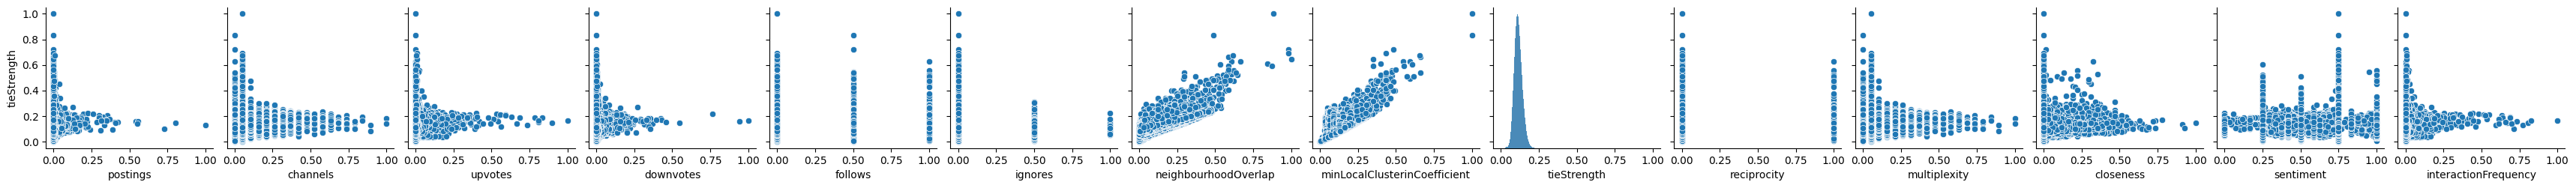

In [61]:
pp = sns.pairplot(data=normalized_df,
                  y_vars=['tieStrength'])

Split the data into train and test set

In [62]:

def equalObs(x, nbin):
    nlen = len(x)
    return np.interp(np.linspace(0, nlen, nbin + 1),
                     np.arange(nlen),
                     np.sort(x))

bins = equalObs(normalized_df['tieStrength'], 10)

bins = bins[1:]


In [63]:
tieStrength = normalized_df.tieStrength.to_numpy()
tieStrengthInBins = np.digitize(tieStrength, bins=bins, right=True)

# drop first bin because it contains just one value
groupCounts = np.bincount(tieStrengthInBins)
groupCounts

array([277522, 277521, 277521, 277521, 277522, 277521, 277521, 277521,
       277521, 277521])

In [64]:
train_set_first, test_set = train_test_split(normalized_df, test_size=0.4, random_state=42, stratify=tieStrengthInBins)
train_set_first

,postings,channels,upvotes,downvotes,follows,ignores,neighbourhoodOverlap,minLocalClusterinCoefficient,tieStrength,reciprocity,multiplexity,closeness,sentiment,interactionFrequency
1997555,0.000000,0.052632,0.000000,0.004329,0.0,0.0,0.058032,0.092424,0.081951,0.0,0.052632,0.0,0.25,0.001613
296601,0.000000,0.000000,0.000000,0.000000,0.5,0.0,0.063083,0.053228,0.059720,0.0,0.000000,0.0,0.75,0.000000
1073697,0.000000,0.000000,0.000000,0.000000,0.0,0.5,0.051786,0.114445,0.092982,0.0,0.000000,0.0,0.25,0.000000
2075463,0.005952,0.052632,0.000000,0.004329,0.0,0.0,0.087359,0.131331,0.118703,0.0,0.052632,0.0,0.25,0.004839
2870626,0.000000,0.052632,0.001996,0.000000,0.0,0.0,0.145311,0.126159,0.140266,0.0,0.052632,0.0,0.75,0.001613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2263867,0.000000,0.052632,0.001996,0.000000,0.0,0.0,0.029615,0.183377,0.126396,0.0,0.052632,0.0,0.75,0.001613
2094704,0.000000,0.052632,0.001996,0.000000,0.0,0.0,0.039233,0.147174,0.107981,0.0,0.052632,0.0,0.75,0.001613
1125691,0.000000,0.052632,0.000000,0.004329,0.0,0.0,0.183065,0.093364,0.136005,0.0,0.052632,0.0,0.25,0.001613
1295439,0.000000,0.052632,0.000000,0.012987,0.0,0.0,0.095638,0.105304,0.106048,0.0,0.052632,0.0,0.25,0.004839


In [65]:
tieStrengthTrain = train_set_first.tieStrength.to_numpy()
tieStrengthTrainInBins = np.digitize(tieStrengthTrain, bins=bins, right=True)

tieStrengthTrainInBins
groupCounts = np.bincount(tieStrengthTrainInBins)
groupCounts

array([166513, 166513, 166513, 166513, 166513, 166512, 166512, 166513,
       166512, 166513])

In [66]:
# Further split the train set into train and validation set
train_set, val_set = train_test_split(train_set_first, test_size=0.4, random_state=42, stratify=tieStrengthTrainInBins) # 0.25 x 0.8 = 0.2
train_set

,postings,channels,upvotes,downvotes,follows,ignores,neighbourhoodOverlap,minLocalClusterinCoefficient,tieStrength,reciprocity,multiplexity,closeness,sentiment,interactionFrequency
2614486,0.0,0.052632,0.000000,0.004329,0.0,0.0,0.041759,0.086509,0.071311,0.0,0.052632,0.0,0.25,0.001613
526782,0.0,0.052632,0.001996,0.000000,0.0,0.0,0.144303,0.137996,0.147201,0.0,0.052632,0.0,0.75,0.001613
2559303,0.0,0.052632,0.001996,0.000000,0.0,0.0,0.056065,0.105168,0.089040,0.0,0.052632,0.0,0.75,0.001613
2263106,0.0,0.105263,0.001996,0.004329,0.0,0.0,0.071491,0.102574,0.094022,0.0,0.105263,0.0,0.50,0.003226
413402,0.0,0.052632,0.000000,0.004329,0.0,0.0,0.098090,0.119818,0.116127,0.0,0.052632,0.0,0.25,0.001613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2478060,0.0,0.052632,0.001996,0.000000,0.0,0.0,0.045760,0.129509,0.099780,0.0,0.052632,0.0,0.75,0.001613
2798678,0.0,0.052632,0.001996,0.000000,0.0,0.0,0.077768,0.088530,0.087968,0.0,0.052632,0.0,0.75,0.001613
2521611,0.0,0.052632,0.001996,0.000000,0.0,0.0,0.091390,0.115362,0.110489,0.0,0.052632,0.0,0.75,0.001613
2084984,0.0,0.052632,0.001996,0.000000,0.0,0.0,0.098845,0.140302,0.129197,0.0,0.052632,0.0,0.75,0.001613


In [69]:
train_set.to_csv('data/interaction_train_set.csv', index=False)
val_set.to_csv('data/interaction_val_set.csv', index=False)
test_set.to_csv('data/interaction_test_set.csv', index=False)